# Biodiversity

## Introduction
The goal of this project is to analyse the biodiversity datasets from National Parks Service. 

This project will analyze, prepare, plot data and seek to explain the findings from the analysis.

**Data sources:**
Both `Observations.csv` and `Species_info.csv` was provided by [Codecademy.com](https://www.codecademy.com).

## Project Goals
The perspektive for this analysis is to gather information about species and their respective conservation status. The following questions were chosen to focus on:
* What is the distribution of conservation status for species?
* Are certain types of species more likely to be endangered?
* Are the differences between species and their conservation status significant?
* Which animal is most prevalent and what is their distribution amongst parks?

# Import modules

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# Loading the data sets

## Observations
Observations.csv contains information about sightings of different species from the past 7 days. The dataset has three columns:
* scientific_name: The scientific name of the species
* park_name: The name of the park
* observations: The number of observations in the past 7 days

In [3]:
obs = pd.read_csv('observations.csv')
obs.head()

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


## Species
Species.csv contains information about the specific species in the national parks. The dataset has four columns:
* category: The category a specific species (e.g. mammal, bird, fish)
* scientific_name: The scientific name of a specific species
* common_names: The common name of a specific species
* conservation_status: A label for the risk of extinction

In [4]:
species = pd.read_csv('species_info.csv')
species.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


# Exploring the datasets

I will check the dimentions if the datasets to get a sence of how many observations they contain.

In [5]:
print(f"Species shape: {species.shape}")
print(f"Observations shape: {obs.shape}")

Species shape: (5824, 4)
Observations shape: (23296, 3)


In [6]:
print(f"Number of observations: {obs.observations.sum()}")

Number of observations: 3314739


That is a lot of observations, but as can be seen in the top 5 rows, each row has several observations. 

Taking a further look at the species dataset

In [7]:
species.groupby("category").size()

category
Amphibian              80
Bird                  521
Fish                  127
Mammal                214
Nonvascular Plant     333
Reptile                79
Vascular Plant       4470
dtype: int64

In [10]:
print(species.groupby("conservation_status").size())
print(f"na values: {species.conservation_status.isna().sum()}")

conservation_status
Endangered              16
In Recovery              4
No intervention       5633
Species of Concern     161
Threatened              10
dtype: int64
na values: 0


Many missing values

The column `conservation_status` has several possible values:
- `Species of Concern`: declining or appear to be in need of conservation
- `Threatened`: vulnerable to endangerment in the near future
- `Endangered`: seriously at risk of extinction
- `In Recovery`: formerly `Endangered`, but currently neither in danger of extinction throughout all or a significant portion of its range

In the exploration, a lot of `nan` values were detected. These values will need to be converted to `No Intervention`.

In [11]:
species.conservation_status.fillna("No intervention", inplace=True)
species.groupby("conservation_status").size()

conservation_status
Endangered              16
In Recovery              4
No intervention       5633
Species of Concern     161
Threatened              10
dtype: int64

In [12]:
# Filter out "No intervention" to focus on species with conservation concerns
species_conservation_only = species[species.conservation_status != "No intervention"]

# Create a crosstab to see the relationship between category and conservation status
category_conservation = pd.crosstab(species_conservation_only.category, species_conservation_only.conservation_status)
print("Categories by Conservation Status (excluding 'No intervention'):")
print(category_conservation)

Categories by Conservation Status (excluding 'No intervention'):
conservation_status  Endangered  In Recovery  Species of Concern  Threatened
category                                                                    
Amphibian                     1            0                   4           2
Bird                          4            3                  72           0
Fish                          3            0                   4           4
Mammal                        7            1                  28           2
Nonvascular Plant             0            0                   5           0
Reptile                       0            0                   5           0
Vascular Plant                1            0                  43           2


<Figure size 1200x800 with 0 Axes>

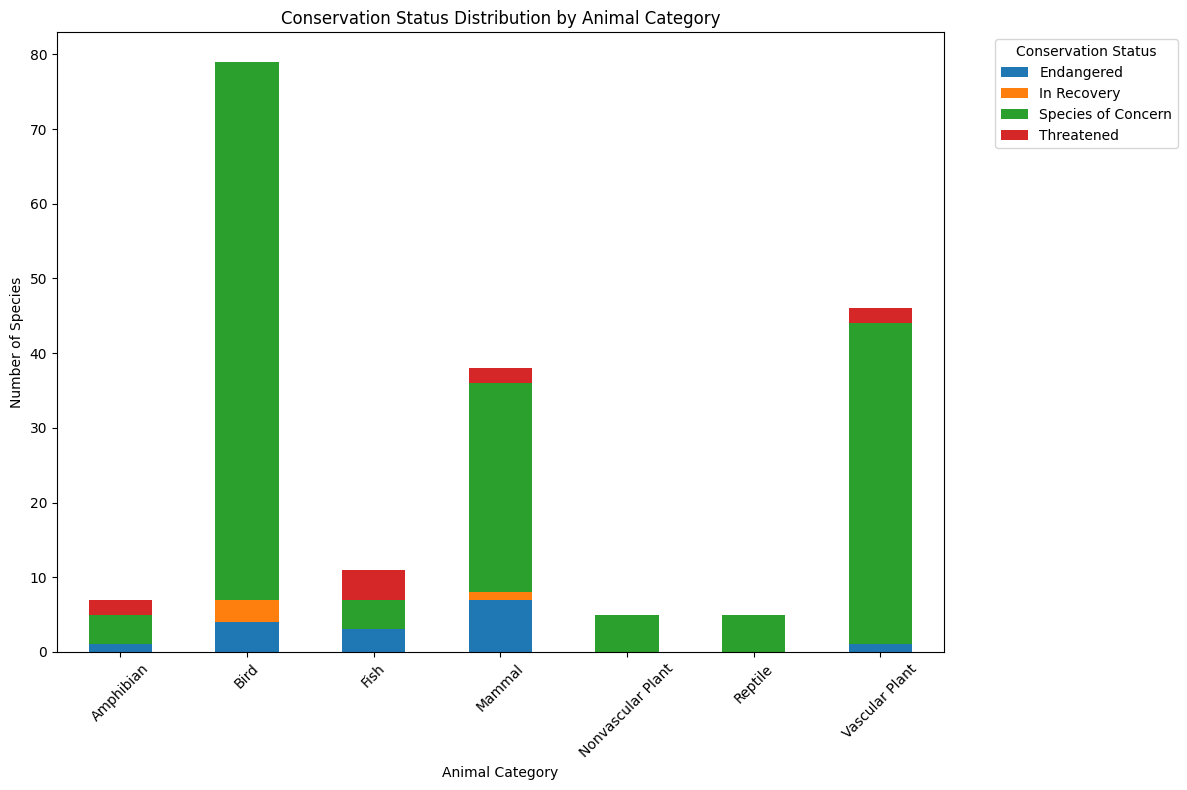

In [13]:
# Create a stacked bar chart
plt.figure(figsize=(12, 8))
category_conservation.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Conservation Status Distribution by Animal Category')
plt.xlabel('Animal Category')
plt.ylabel('Number of Species')
plt.xticks(rotation=45)
plt.legend(title='Conservation Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Now I know the distribution of animal-categories in the different conservation statuses. 

I want to look closer into what kinds of speices are in the different categories. I create a new cloumn for speices which are protected.

In [15]:
species["is_protected"] = species.conservation_status != 'No intervention'

Now i want to create a new dataframe which contains the categories and how many of these categories are protected and not_protected.

In [17]:
category_counts = species.groupby(['category', 'is_protected'])\
                        .scientific_name.nunique()\
                        .reset_index()\
                        .pivot(columns='is_protected',
                                      index='category',
                                      values='scientific_name')\
                        .reset_index()
category_counts.columns = ['category', 'not_protected', 'protected']

category_counts

,category,not_protected,protected
0,Amphibian,72,7
1,Bird,413,75
2,Fish,115,11
3,Mammal,146,30
4,Nonvascular Plant,328,5
5,Reptile,73,5
6,Vascular Plant,4216,46


And shown in procentages:

In [18]:
category_counts['percent_protected'] = category_counts.protected / \
                                      (category_counts.protected + category_counts.not_protected) * 100

category_counts

,category,not_protected,protected,percent_protected
0,Amphibian,72,7,8.860759
1,Bird,413,75,15.368852
2,Fish,115,11,8.730159
3,Mammal,146,30,17.045455
4,Nonvascular Plant,328,5,1.501502
5,Reptile,73,5,6.410256
6,Vascular Plant,4216,46,1.079305


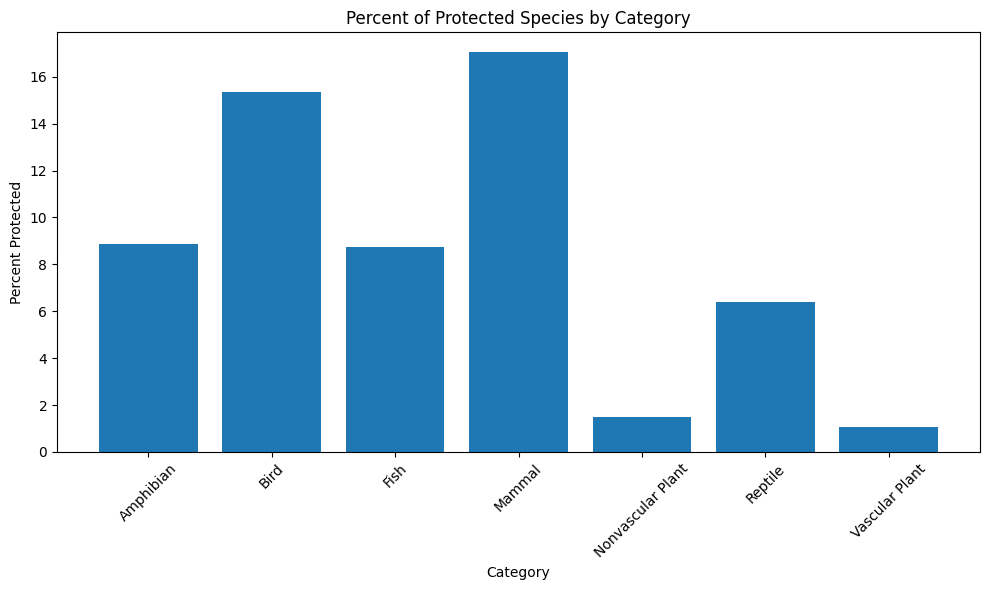

In [20]:
plt.figure(figsize=(10,6))
plt.bar(category_counts.category, category_counts.percent_protected)
plt.xlabel('Category')
plt.ylabel('Percent Protected')
plt.title('Percent of Protected Species by Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()